## Shell Contact Example

In [1]:
# !pip install debugpy

In [2]:
import numpy as np

import dismech


geom = dismech.GeomParams(rod_r0=0.005,
                          shell_h=0.005)

material = dismech.Material(density=1200,
                            youngs_rod=0,
                            youngs_shell=2e7,
                            poisson_rod=0,
                            poisson_shell=0.5)

shell_contact_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=False,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-3,
                                  max_iter=120,
                                  total_time=1.0,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))
# env.add_force('floorContact', ground_z=-1e-3, stiffness=1e3, delta=2e-3, h=1e-3)
env.add_force('selfContact', delta=1e-4, h=5e-3, kc=1)
env.add_force('damping', eta = 20)
#env.set_static()   

# geo = dismech.Geometry.from_txt('input_shell_more_curved.txt')
# geo = dismech.Geometry.from_txt('input_oneTriangle.txt')
geo = dismech.Geometry.from_txt('input_twoTriangleContact_p2p.txt')

robot = dismech.SoftRobot(geom, material, geo, shell_contact_sim, env)

In [3]:
from src.dismech.contact.shell_contact_energy import ShellContactEnergy
# from contact_pairs import ContactPair  # you will need to provide this list

q0 = robot.state.q.copy()
n_dof = q0.size
contact_energy = ShellContactEnergy(robot.tri_contact_pairs, delta=1e-1, h=5e-2, kc=1, k_1 = None, scale = False)

delta: 0.1
h: 0.05
K1: 150.0
scale:  1.0
kc:  1
upper limit for quadratic: 0.0
upper limit for smooth: 0.2


In [4]:
print(np.shape(robot.tri_contact_pairs))
print(robot.tri_contact_pairs[0].pair_nodes)

(1,)
[0 1 2 3 4 5]


In [5]:
# Define energy and gradient functions
def energy_fn(q):
    return contact_energy.get_energy(q, output_scalar=True)

def grad_fn(q):
    F_dummy = np.zeros_like(q)
    grad_E, _, = contact_energy.grad_hess_energy(
        type('State', (object,), {'q': q}), robot, F_dummy, first_iter=False
    )
    return grad_E


In [6]:
analytical_grad = grad_fn(q0)
print("analytical_grad_Econ", analytical_grad)

analytical_grad_Econ [ 0.          0.         -0.00462098  0.          0.          0.
  0.          0.          0.          0.          0.          0.00462098
  0.          0.          0.          0.          0.          0.        ]


Relative difference: 2.500170979529715e-06
analytical_grad_Econ [-0.         -0.          0.00462098 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.00462098
 -0.         -0.         -0.         -0.         -0.         -0.        ]
numerical_grad:  [ 1.15524554e-08  0.00000000e+00  4.62098116e-03  0.00000000e+00
  0.00000000e+00  1.15528518e-10  0.00000000e+00  0.00000000e+00
  5.77473182e-11 -1.15524554e-08  0.00000000e+00 -4.62098116e-03
  0.00000000e+00  0.00000000e+00 -5.77473182e-11  0.00000000e+00
  0.00000000e+00 -1.15528518e-10]


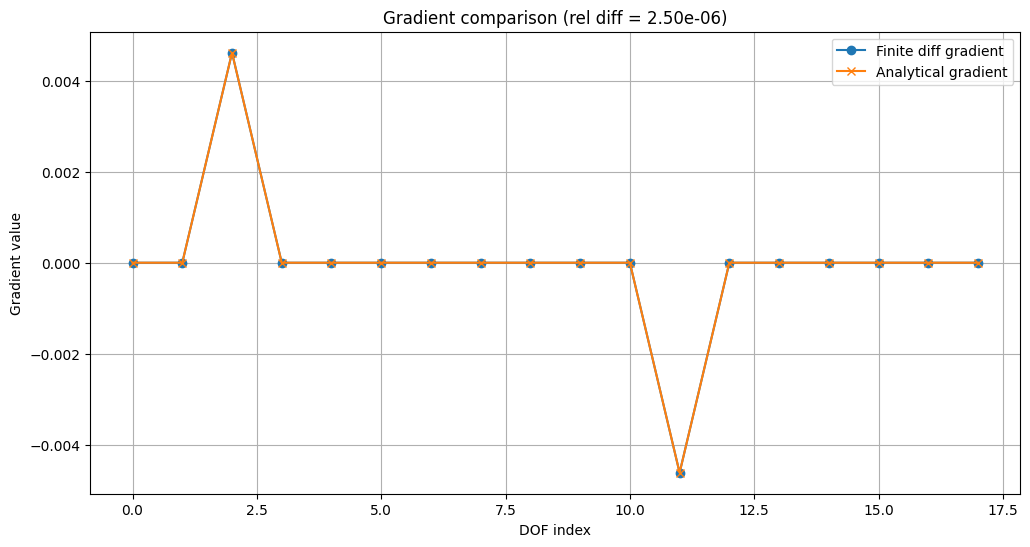

In [7]:
import matplotlib.pyplot as plt

# Finite difference check
def finite_difference_gradient_check(energy_fn, grad_fn, q0, eps=1e-6):
    n = q0.size
    numerical_grad = np.zeros(n)
    f0 = energy_fn(q0)
    for i in range(n):
        q_plus = q0.copy()
        q_minus = q0.copy()
        q_plus[i] += eps
        q_minus[i] -= eps
        f_plus = energy_fn(q_plus)
        f_minus = energy_fn(q_minus)
        numerical_grad[i] = (f_plus - f_minus) / (2 * eps)
    analytical_grad = -grad_fn(q0)
    diff = np.linalg.norm(numerical_grad - analytical_grad) / (np.linalg.norm(analytical_grad) + 1e-12)
    return numerical_grad, analytical_grad, diff

numerical_grad, analytical_grad, rel_diff = finite_difference_gradient_check(energy_fn, grad_fn, q0)

print("Relative difference:", rel_diff)

print("analytical_grad_Econ", analytical_grad)

print("numerical_grad: ", numerical_grad)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(numerical_grad, label='Finite diff gradient', marker='o')
plt.plot(analytical_grad, label='Analytical gradient', marker='x')
plt.legend()
plt.title(f'Gradient comparison (rel diff = {rel_diff:.2e})')
plt.xlabel('DOF index')
plt.ylabel('Gradient value')
plt.grid(True)
plt.show()

mask1:  [False False False False False False False False False False]
mask2:  [ True  True False False False False False False False False]
2h-delta:  0.09000000000000001
2h-delta:  0.11
mask1:  [False False False False False False False False False False]
mask2:  [ True  True False False False False False False False False]
2h-delta:  0.09000000000000001
2h-delta:  0.11
mask1:  [False False False False False False False False False False]
mask2:  [ True  True False False False False False False False False]
2h-delta:  0.09000000000000001
2h-delta:  0.11
E_plus: [2.13072998e-07 2.56727112e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
E_minus: [2.13997194e-07 2.56727112e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
mask1:  [False False False False False False False False False False]
mask2:  [ True  True False False False False

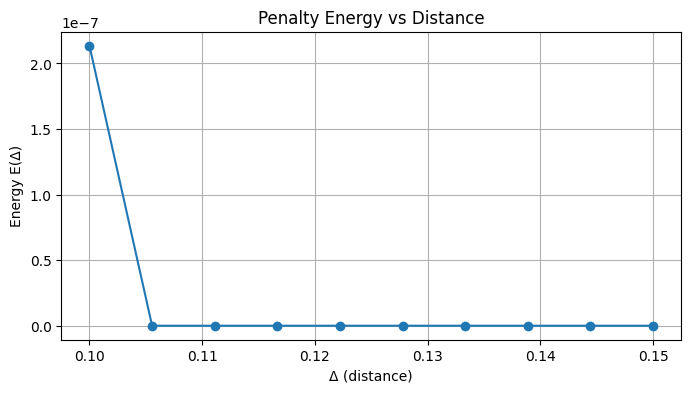

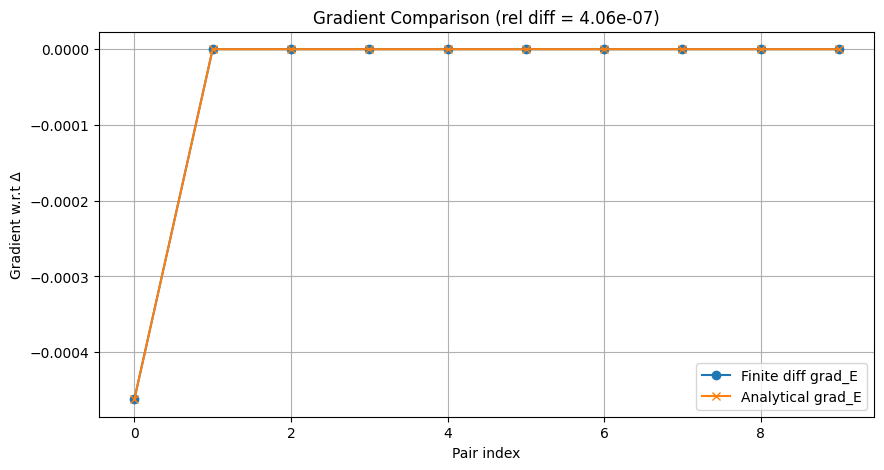

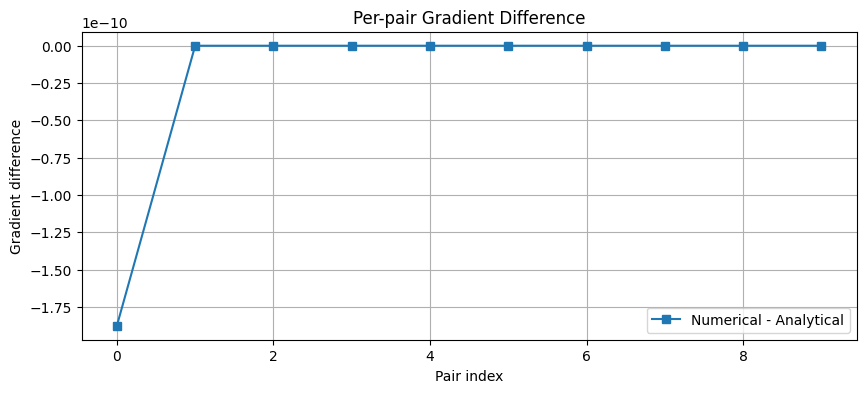

In [8]:
import numpy as np


def compute_energy_grad_hess(Delta, delta, h, k_1):
    E = np.zeros_like(Delta)
    grad_E = np.zeros_like(Delta)
    hess_E = np.zeros_like(Delta)

    mask1 = (Delta > 0) & (Delta <= 2 * h - delta)
    mask2 = (Delta > 2 * h - delta) & (Delta < 2 * h + delta)

    print("mask1: ", mask1)
    print("mask2: ", mask2)
    print("2h-delta: ", 2 * h - delta)
    print("2h-delta: ", 2 * h + delta)

    # Quadratic region
    E[mask1] = (2 * h - Delta[mask1]) ** 2
    grad_E[mask1] = -2 * (2 * h - Delta[mask1])
    hess_E[mask1] = 2.0

    # Smooth transition region
    exp_term = np.exp(k_1 * (2 * h - Delta[mask2]))
    log_term = np.log(1 + exp_term)
    denom = 1 + exp_term

    E[mask2] = (1 / k_1 * log_term) ** 2
    grad_E[mask2] = -2 * (1 / k_1 * log_term) * (exp_term / denom)
    hess_E[mask2] = (
        2 * exp_term / (k_1 * denom ** 2) *
        (log_term - (k_1 * exp_term / denom))
    )

    return E, grad_E, hess_E

def finite_difference_check_energy_grad(Delta, delta, h, k_1, eps=1e-6):
    """
    Compares analytical grad_E (from compute_energy_grad_hess)
    against finite difference on E(Delta).
    
    Parameters:
    - Delta: np.array of input distances (shape [n])
    - delta, h, k_1: penalty parameters
    - eps: finite difference step size
    
    Returns:
    - numerical_grad_E: finite difference gradient (shape [n])
    - analytical_grad_E: computed gradient from function (shape [n])
    - rel_diff: relative difference (normed)
    """
    n = Delta.size
    numerical_grad_E = np.zeros(n)

    # Compute analytical E, grad_E
    E, analytical_grad_E, _ = compute_energy_grad_hess(Delta, delta, h, k_1)

    # Compute finite difference gradient
    for i in range(n):
        Delta_plus = Delta.copy()
        Delta_minus = Delta.copy()
        if Delta[i] == 0:
            Delta_minus[i] -= 0
            const = 1.0
        else:
            Delta_minus[i] -= eps
            const = 2.0

        Delta_plus[i] += eps

        E_plus, _, _ = compute_energy_grad_hess(Delta_plus, delta, h, k_1)
        E_minus, _, _ = compute_energy_grad_hess(Delta_minus, delta, h, k_1)

        print("E_plus:", E_plus)
        print("E_minus:", E_minus)

        numerical_grad_E[i] = (E_plus[i] - E_minus[i]) / (const * eps)

    # Relative difference
    rel_diff = np.linalg.norm(numerical_grad_E - analytical_grad_E) / (np.linalg.norm(analytical_grad_E) + 1e-12)

    return E, numerical_grad_E, analytical_grad_E, rel_diff

# Example setup
n_pairs = 10
Delta = np.linspace(0.1, 0.15, n_pairs)  # sweep distances from 0 to 0.15
# Delta = np.random.rand(n_pairs)
delta = 0.01
h = 0.05
k_1 = 15 / delta

E_vals, num_grad, ana_grad, diff = finite_difference_check_energy_grad(Delta, delta, h, k_1)

print("Relative difference (grad E):", diff)

# Plot: Energy vs Δ
plt.figure(figsize=(8, 4))
plt.plot(Delta, E_vals, marker='o')
plt.xlabel('Δ (distance)')
plt.ylabel('Energy E(Δ)')
plt.title('Penalty Energy vs Distance')
plt.grid(True)
plt.show()

# Plot: Gradients
plt.figure(figsize=(10, 5))
plt.plot(num_grad, label='Finite diff grad_E', marker='o')
plt.plot(ana_grad, label='Analytical grad_E', marker='x')
plt.xlabel('Pair index')
plt.ylabel('Gradient w.r.t Δ')
plt.title(f'Gradient Comparison (rel diff = {diff:.2e})')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Per-pair difference plot
plt.figure(figsize=(10, 4))
plt.plot(num_grad - ana_grad, label='Numerical - Analytical', marker='s')
plt.xlabel('Pair index')
plt.ylabel('Gradient difference')
plt.title('Per-pair Gradient Difference')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import numpy as np

def finite_difference_grad_delta_check(delta_fn, grad_delta_fn, q0, eps=1e-6):
    n = q0.size
    batch_size = delta_fn(q0).size  # number of contact pairs

    numerical_grad = np.zeros((batch_size, n))
    f0 = delta_fn(q0)

    for i in range(n):
        q_plus = q0.copy()
        q_minus = q0.copy()
        q_plus[i] += eps
        q_minus[i] -= eps

        f_plus = delta_fn(q_plus)
        f_minus = delta_fn(q_minus)

        numerical_grad[:, i] = (f_plus - f_minus) / (2 * eps)

    analytical_grad = grad_delta_fn(q0)  # shape (batch_size, n)
    diff = np.linalg.norm(numerical_grad - analytical_grad) / (np.linalg.norm(analytical_grad) + 1e-12)

    return numerical_grad, analytical_grad, diff


Relative difference (grad Δ): 2.500187672636373e-06


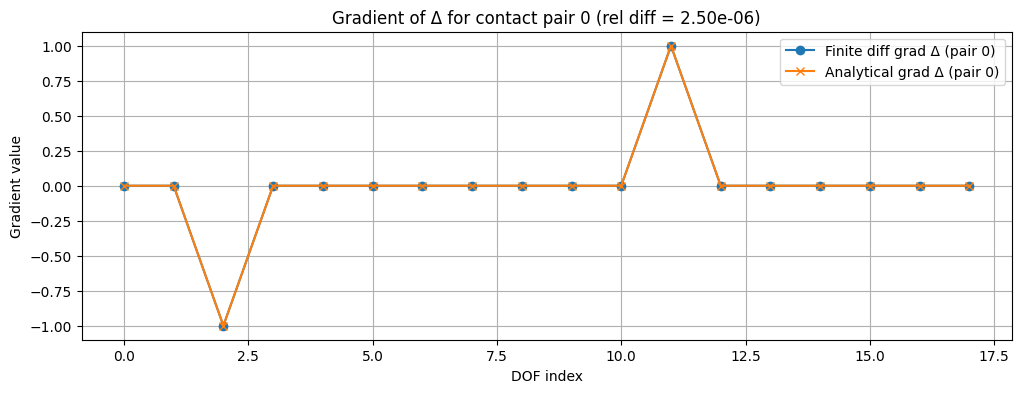

In [10]:
q0 = robot.state.q.copy()
n_dof = q0.size

def delta_fn(q):
    return contact_energy.get_Delta(q)  # returns (batch_size,)

def grad_delta_fn(q):
    grad_Delta, _ = contact_energy.get_grad_hess_Delta(q)
    return grad_Delta  # should be (batch_size, n_dof)

numerical_grad, analytical_grad, rel_diff = finite_difference_grad_delta_check(delta_fn, grad_delta_fn, q0)

print("Relative difference (grad Δ):", rel_diff)

# Plot per-contact comparison
import matplotlib.pyplot as plt

for i in range(numerical_grad.shape[0]):
    plt.figure(figsize=(12, 4))
    plt.plot(numerical_grad[i], label=f'Finite diff grad Δ (pair {i})', marker='o')
    plt.plot(analytical_grad[i], label=f'Analytical grad Δ (pair {i})', marker='x')
    plt.legend()
    plt.title(f'Gradient of Δ for contact pair {i} (rel diff = {rel_diff:.2e})')
    plt.xlabel('DOF index')
    plt.ylabel('Gradient value')
    plt.grid(True)
    plt.show()
